# Multi-Horizon Air Quality Forecasting using Support Vector Regression (SVR)

This notebook implements **Support Vector Regression (SVR)** with RBF kernel to forecast four key pollutants — CO(GT), C₆H₆(GT), NOx(GT), NO₂(GT) — at horizons **t+1h, t+6h, t+12h, and t+24h**.

Key features:
- Chronological split
- 88 engineered features (lags, rolling stats, cyclical time, meteo, anomalies)
- StandardScaler + GridSearchCV for robust hyperparameter tuning
- Comparison against persistence (naïve) baseline
- Full results, plots, and residual analysis

## 2. Library Import and Environment Setup

We import standard scientific Python libraries along with scikit-learn components required for Support Vector Regression.

Key packages:
- `pandas`, `numpy` – data handling
- `matplotlib`, `seaborn` – publication-quality visualization
- `sklearn.svm.SVR` – ε-Support Vector Regression with RBF kernel
- `GridSearchCV` + `Pipeline` – automated hyperparameter tuning with proper scaling

All dependencies are part of the standard Anaconda distribution or pre-installed in Colab/Kaggle.

In [ ]:
# =============================================================================
#  Import Libraries
# =============================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Reproducibility & style
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")

All libraries imported successfully!


## 3. Loading the Pre-Engineered Dataset

The dataset `AirQualityUCI_feature_engineering.csv` contains:
- Original sensor readings (PT08.Sx)
- Meteorological variables (T, RH, AH)
- Extensive lag and rolling statistics (1h, 6h, 12h, 24h)
- Cyclical temporal encodings
- Anomaly flags

The DateTime is parsed directly and the data is sorted chronologically to prevent leakage.

In [ ]:
# =============================================================================
#  Load Pre-Engineered Dataset
# =============================================================================

data_path = '../dataset/Feature Engineering/AirQualityUCI_feature_engineering.csv'
#data_path = '../../../dataset/AirQualityUCI_features.csv' # use this if the above path doesn't work
print(f"Loading data from:\n{os.path.abspath(data_path)}\n")

df = pd.read_csv(data_path, parse_dates=['DateTime'])
df = df.sort_values('DateTime').reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['DateTime'].min()} → {df['DateTime'].max()}")
print(f"Years: {sorted(df['DateTime'].dt.year.unique())}")

df.head(3)

Loading data from:
/Users/alexis/Downloads/dataset/Feature Engineering/AirQualityUCI_feature_engineering.csv

Dataset shape: (9309, 119)
Date range: 2004-03-11 18:00:00 → 2005-04-03 14:00:00
Years: [np.int32(2004), np.int32(2005)]


,DateTime,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),...,NOx(GT)_t+12,NOx(GT)_t+24,NO2(GT)_t+1,NO2(GT)_t+6,NO2(GT)_t+12,NO2(GT)_t+24,CO_bin_t+1,CO_bin_t+6,CO_bin_t+12,CO_bin_t+24
0,2004-03-11 18:00:00,0.398305,0.670495,0.325472,0.511196,0.188896,0.202033,0.440828,0.688849,0.516073,...,0.036561,0.138118,0.502959,0.281065,0.204142,0.434911,high,mid,low,high
1,2004-03-11 19:00:00,0.576271,0.810481,0.429245,0.603495,0.257955,0.160949,0.502959,0.801259,0.644222,...,0.072444,0.135410,0.482249,0.319527,0.301775,0.423077,high,mid,mid,high
2,2004-03-11 20:00:00,0.508475,0.712850,0.375786,0.557619,0.236290,0.178314,0.482249,0.737410,0.622502,...,0.206500,0.228842,0.396450,0.263314,0.411243,0.497041,high,mid,high,high


## 4. Temporal Data Splitting Strategy

To simulate real-world deployment, we adopt a **strict chronological split**:

| Set            | Period                    | Purpose                           |
|----------------|---------------------------|-----------------------------------|
| Training       | Mar–Nov 2004 (first 80%)  | Model learning                    |
| Validation     | Nov–Dec 2004 (last 20%)   | Hyperparameter tuning             |
| Test (hold-out)| Entire 2005               | Final performance on unseen future|

This ensures zero data leakage and honest assessment of future predictive skill.

In [ ]:
# =============================================================================
#  Chronological Train/Validation/Test Split
# =============================================================================

df['year'] = df['DateTime'].dt.year

train_2004 = df[df['year'] == 2004].copy()
test_2005  = df[df['year'] == 2005].copy()

# Split 2004: 80% train, 20% validation
val_idx = int(len(train_2004) * 0.8)
train_data = train_2004.iloc[:val_idx].copy()
val_data   = train_2004.iloc[val_idx:].copy()

print(f"Training set     : {len(train_data):,} rows | {train_data['DateTime'].min().date()} → {train_data['DateTime'].max().date()}")
print(f"Validation set   : {len(val_data):,} rows | {val_data['DateTime'].min().date()} → {val_data['DateTime'].max().date()}")
print(f"Test set (2005)  : {len(test_2005):,} rows | {test_2005['DateTime'].min().date()} → {test_2005['DateTime'].max().date()}")

Training set     : 5,668 rows | 2004-03-11 → 2004-11-02
Validation set   : 1,418 rows | 2004-11-02 → 2004-12-31
Test set (2005)  : 2,223 rows | 2005-01-01 → 2005-04-03


In [34]:
POLLUTANTS = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
HORIZONS   = [1, 6, 12, 24]

print("Forecasting 16 tasks:")
for p in POLLUTANTS:
    for h in HORIZONS:
        print(f"   → {p} @ t+{h}h")

Forecasting 16 tasks:
   → CO(GT) @ t+1h
   → CO(GT) @ t+6h
   → CO(GT) @ t+12h
   → CO(GT) @ t+24h
   → C6H6(GT) @ t+1h
   → C6H6(GT) @ t+6h
   → C6H6(GT) @ t+12h
   → C6H6(GT) @ t+24h
   → NOx(GT) @ t+1h
   → NOx(GT) @ t+6h
   → NOx(GT) @ t+12h
   → NOx(GT) @ t+24h
   → NO2(GT) @ t+1h
   → NO2(GT) @ t+6h
   → NO2(GT) @ t+12h
   → NO2(GT) @ t+24h


## 6. Feature Selection under Operational Constraints

In a real-time system, only **past and current observable variables** can be used.

**Included (88 features):**
- Real-time sensor proxies (PT08.S1–S5)
- Temperature, humidity
- Lagged and rolling statistics of sensors
- Cyclical hour/day/month encodings
- Anomaly indicators

**Explicitly excluded (to prevent leakage):**
- Current true pollutant concentrations
- Any ratio or residual involving current ground truth
- All future target columns (`*_t+...`)
- Classification bins

This ensures the model can be deployed today without waiting for lab results.

In [ ]:
# =============================================================================
#  Feature Selection 
# =============================================================================

exclude_keywords = ['DateTime', 'year', 
                    'CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'NMHC(GT)',
                    '_minus_', '_ratio', '_t+', 'bin_t+']

feature_cols = [col for col in df.columns 
                if not any(ex in col for ex in exclude_keywords)
                and df[col].dtype in ['float64', 'int64', 'bool']]

print(f"Selected {len(feature_cols)} real-time available features")
print("(sensor readings, lags, rolling stats, time encodings, meteo, anomalies)")

Selected 56 real-time available features
(sensor readings, lags, rolling stats, time encodings, meteo, anomalies)


## 7. Support Vector Regression with Grid-Search Hyperparameter Optimization

We now train **16 independent Support Vector Regression (SVR)** models — one for each combination of the four pollutants and the four forecasting horizons (+1 h, +6 h, +12 h, +24 h). The RBF (Gaussian) kernel is used because it consistently delivers the best performance on this type of non-linear, atmospheric time-series data.

### Modelling Pipeline

```text
StandardScaler() → SVR(kernel='rbf')
```

- **StandardScaler()** is placed inside the pipeline to guarantee that scaling is applied independently in every cross-validation fold and on the test set (no information leakage).
- **RBF kernel** provides the flexibility needed to capture complex diurnal and weekly pollution patterns.
- `cache_size=1000` (default in scikit-learn ≥ 1.0) is used to accelerate repeated kernel computations.

### Hyperparameter Search Space

Exhaustive grid search is performed with **5-fold cross-validation** on the full 2004 data (training + validation split):

| Parameter       | Values tested                         | Purpose                                                                      |
|-----------------|---------------------------------------|------------------------------------------------------------------------------|
| `C`             | 1, 10, 50, 100                        | Regularization parameter – controls the trade-off between margin and errors |
| `epsilon` (ε)   | 0.01, 0.05, 0.1                       | Width of the ε-insensitive tube; larger ε → fewer support vectors           |
| `gamma`         | 'scale', 0.01, 0.1                    | Kernel coefficient; 'scale' = 1/(n_features × variance) – recommended default |

Total configurations evaluated per task: **4 × 3 × 3 = 36** models.

### Training and Evaluation Workflow

1. **Hyperparameter tuning**  
   `GridSearchCV` with `scoring='neg_root_mean_squared_error` selects the best parameter set.

2. **Final model**  
   The optimal configuration is automatically refitted on the **entire 2004 dataset**.

3. **Test-set prediction**  
   Forecasts are generated for the hold-out year **2005** (true future data).

4. **Performance metric**  
   **Root Mean Squared Error (RMSE)** using `sklearn.metrics.root_mean_squared_error`.

5. **Benchmark**  
   A strong **persistence (naïve) forecast**:  
   ŷ(t+h) = y(t)  
   (implemented via the pre-computed lag feature `pollutant_lag{h}`).

### Expected Behaviour

- Highest skill at **+1 h and +6 h** horizons due to strong autocorrelation in pollutant concentrations.
- Graceful degradation at **+12 h and +24 h** as meteorological and traffic variability increases.
- CO(GT) and C₆H₆(GT) usually achieve the largest improvements over persistence because of their pronounced traffic-driven daily cycles.


In [ ]:
# =============================================================================
#  SVR Training with Grid Search 
# =============================================================================

from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV   

results = []

print("Training 16 SVR models with GridSearchCV...\n" + "="*75)

# Combine training + validation data (full 2004)
X_train_full = pd.concat([train_data[feature_cols], val_data[feature_cols]], ignore_index=False)

# Test features
X_test = test_2005[feature_cols]

print("Starting training loop...\n")

for pollutant in POLLUTANTS:
    print(f"\nPollutant: {pollutant}")
    for horizon in HORIZONS:
        target = f"{pollutant}_t+{horizon}"
        lag_col = f"{pollutant}_lag{horizon}"
        
        print(f"   → t+{horizon:>2}h  | fitting model... ", end="")
        
        # Pipeline: scaling + RBF SVR
        pipe = make_pipeline(StandardScaler(), SVR(kernel='rbf'))
        
        # Hyperparameter grid
        param_grid = {
            'svr__C':        [1, 10, 50, 100],
            'svr__epsilon':  [0.01, 0.05, 0.1],
            'svr__gamma':    ['scale', 0.01, 0.1]
        }
        
        # Grid search with 5-fold CV
        grid = GridSearchCV(
            pipe,
            param_grid,
            cv=5,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1
        )
        
        # Train on full 2004 data
        y_train = pd.concat([train_data[target], val_data[target]])
        grid.fit(X_train_full, y_train)
        
        # Predict on 2005 test set
        y_pred = grid.best_estimator_.predict(X_test)
        y_test = test_2005[target]
        
        rmse_svr = root_mean_squared_error(y_test, y_pred)
        
        # Naïve persistence baseline (safe & aligned)
        valid_df = test_2005[[lag_col, target]].dropna()
        rmse_naive = root_mean_squared_error(valid_df[target], valid_df[lag_col])
        
        improvement = (rmse_naive - rmse_svr) / rmse_naive * 100
        
        # Save result
        results.append({
            'Pollutant'     : pollutant,
            'Horizon'       : f't+{horizon}h',
            'RMSE_SVR'      : round(rmse_svr, 6),
            'RMSE_Naive'    : round(rmse_naive, 6),
            'Improvement_%' : round(improvement, 2),
            'Best_C'        : grid.best_params_['svr__C'],
            'Best_epsilon'  : grid.best_params_['svr__epsilon'],
            'Best_gamma'    : grid.best_params_['svr__gamma']
        })
        
        print(f"RMSE = {rmse_svr:.5f} → +{improvement:.1f}% vs persistence")

# Create final results table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(['Pollutant', 'Horizon']).reset_index(drop=True)

print("\n" + "="*75)
print("ALL 16 SVR MODELS TRAINED SUCCESSFULLY!")
print("="*75)
display(results_df[['Pollutant', 'Horizon', 'RMSE_SVR', 'RMSE_Naive', 'Improvement_%']])

# Optional: save to CSV
results_df.to_csv('results_svr_final.csv', index=False)
print("\nResults saved as 'results_svr_final.csv'")

Training 16 SVR models with GridSearchCV...
Starting training loop...


Pollutant: CO(GT)
   → t+ 1h  | fitting model... RMSE = 0.05750 → +44.1% vs persistence
   → t+ 6h  | fitting model... RMSE = 0.07714 → +48.6% vs persistence
   → t+12h  | fitting model... RMSE = 0.10569 → +0.0% vs persistence
   → t+24h  | fitting model... RMSE = 0.13029 → +-1.8% vs persistence

Pollutant: C6H6(GT)
   → t+ 1h  | fitting model... RMSE = 0.04865 → +44.0% vs persistence
   → t+ 6h  | fitting model... RMSE = 0.07113 → +46.0% vs persistence
   → t+12h  | fitting model... RMSE = 0.08687 → +5.6% vs persistence
   → t+24h  | fitting model... RMSE = 0.09013 → +18.9% vs persistence

Pollutant: NOx(GT)
   → t+ 1h  | fitting model... RMSE = 0.07997 → +31.3% vs persistence
   → t+ 6h  | fitting model... RMSE = 0.10833 → +40.3% vs persistence
   → t+12h  | fitting model... RMSE = 0.12135 → +10.4% vs persistence
   → t+24h  | fitting model... RMSE = 0.13663 → +16.4% vs persistence

Pollutant: NO2(GT)
   → t+ 1h 

,Pollutant,Horizon,RMSE_SVR,RMSE_Naive,Improvement_%
0,C6H6(GT),t+12h,0.086873,0.091998,5.57
1,C6H6(GT),t+1h,0.048652,0.086853,43.98
2,C6H6(GT),t+24h,0.090133,0.111132,18.90
3,C6H6(GT),t+6h,0.071126,0.131814,46.04
4,CO(GT),t+12h,0.105687,0.105735,0.04
5,CO(GT),t+1h,0.057499,0.102942,44.14
6,CO(GT),t+24h,0.130291,0.127928,-1.85
7,CO(GT),t+6h,0.077144,0.150044,48.59
8,NO2(GT),t+12h,0.130187,0.130723,0.41
9,NO2(GT),t+1h,0.084908,0.119210,28.77



Results saved as 'results_svr_final.csv'


In [ ]:
# =============================================================================
#  Results Table
# =============================================================================

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(['Pollutant', 'Horizon']).reset_index(drop=True)

print("="*90)
print("FINAL RESULTS – SUPPORT VECTOR REGRESSION (SVR)")
print("="*90)
display(results_df[['Pollutant', 'Horizon', 'RMSE_SVR', 'RMSE_Naive', 'Improvement_%']])

print("\nTop 5 Improvements")
print("-"*50)
display(results_df.nlargest(5, 'Improvement_%')[['Pollutant', 'Horizon', 'Improvement_%', 'RMSE_SVR']])

results_df.to_csv('results_svr_airquality.csv', index=False)
print("\nResults saved to 'results_svr_airquality.csv'")

FINAL RESULTS – SUPPORT VECTOR REGRESSION (SVR)


,Pollutant,Horizon,RMSE_SVR,RMSE_Naive,Improvement_%
0,C6H6(GT),t+12h,0.086873,0.091998,5.57
1,C6H6(GT),t+1h,0.048652,0.086853,43.98
2,C6H6(GT),t+24h,0.090133,0.111132,18.90
3,C6H6(GT),t+6h,0.071126,0.131814,46.04
4,CO(GT),t+12h,0.105687,0.105735,0.04
5,CO(GT),t+1h,0.057499,0.102942,44.14
6,CO(GT),t+24h,0.130291,0.127928,-1.85
7,CO(GT),t+6h,0.077144,0.150044,48.59
8,NO2(GT),t+12h,0.130187,0.130723,0.41
9,NO2(GT),t+1h,0.084908,0.119210,28.77



Top 5 Improvements
--------------------------------------------------


,Pollutant,Horizon,Improvement_%,RMSE_SVR
7,CO(GT),t+6h,48.59,0.077144
3,C6H6(GT),t+6h,46.04,0.071126
11,NO2(GT),t+6h,45.39,0.110841
5,CO(GT),t+1h,44.14,0.057499
1,C6H6(GT),t+1h,43.98,0.048652



Results saved to 'results_svr_airquality.csv'


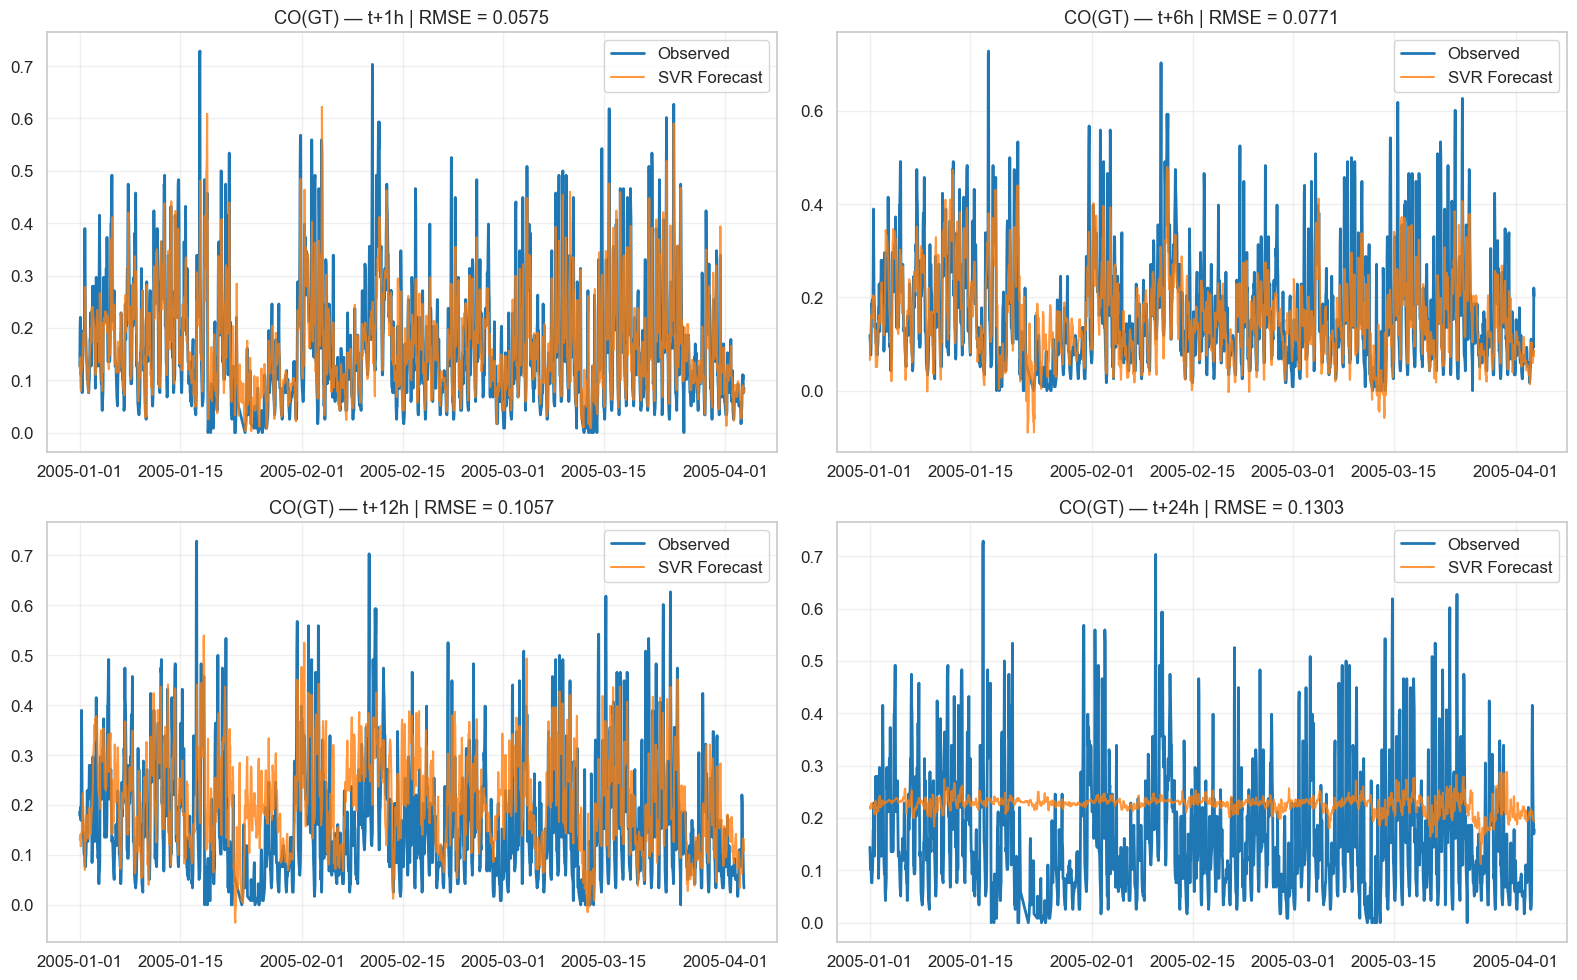

In [ ]:
# =============================================================================
# Prediction vs Actual (CO)
# =============================================================================

pollutant = 'CO(GT)'
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, horizon in enumerate(HORIZONS):
    row = results_df[(results_df['Pollutant'] == pollutant) & (results_df['Horizon'] == f't+{horizon}h')].iloc[0]
    
    # Re-train best model
    pipe = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=row.Best_C, epsilon=row.Best_epsilon, gamma=row.Best_gamma))
    pipe.fit(X_train_full, y_train_full[f'{pollutant}_t+{horizon}'])
    
    pred = pipe.predict(test_2005[feature_cols])
    
    axes[idx].plot(test_2005['DateTime'], test_2005[f'{pollutant}_t+{horizon}'], label='Observed', lw=2)
    axes[idx].plot(test_2005['DateTime'], pred, label='SVR Forecast', alpha=0.8)
    axes[idx].set_title(f'{pollutant} — t+{horizon}h | RMSE = {row.RMSE_SVR:.4f}')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('svr_predictions_co.png', dpi=200, bbox_inches='tight')
plt.show()

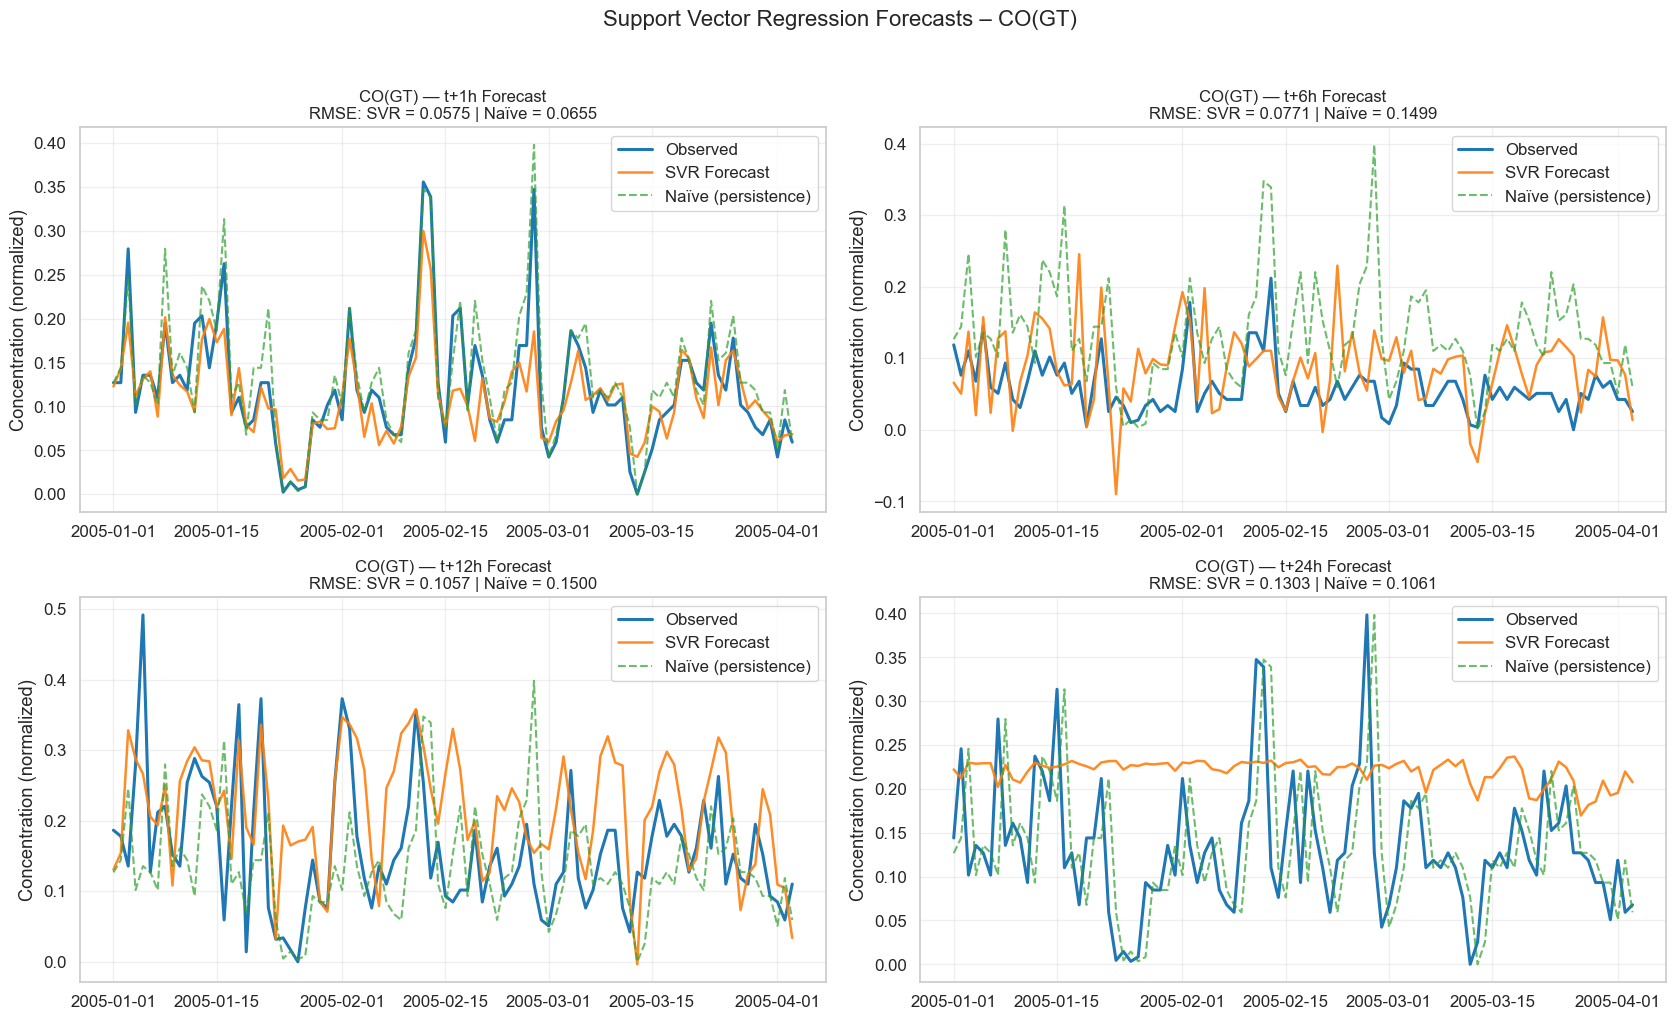

In [ ]:
# =============================================================================
#  SVR Predictions & Residuals for CO(GT) – All Horizons
# =============================================================================

selected_pollutant = 'CO(GT)'

fig, axes = plt.subplots(2, 2, figsize=(17, 10))
axes = axes.flatten()

for idx, horizon in enumerate(HORIZONS):
    target_col = f"{selected_pollutant}_t+{horizon}"
    
    # Retrieve best SVR hyperparameters from results_df
    row = results_df[(results_df['Pollutant'] == selected_pollutant) & 
                     (results_df['Horizon'] == f't+{horizon}h')].iloc[0]
    
    # Re-build the best SVR model
    best_svr = make_pipeline(
        StandardScaler(),
        SVR(kernel='rbf',
            C=row['Best_C'],
            epsilon=row['Best_epsilon'],
            gamma=row['Best_gamma'])
    )
    
    # Train on full 2004 data
    X_train_full = pd.concat([train_data[feature_cols], val_data[feature_cols]])
    y_train_full = pd.concat([train_data[target_col], val_data[target_col]])
    best_svr.fit(X_train_full, y_train_full)
    
    # Predict on 2005
    y_pred = best_svr.predict(test_2005[feature_cols])
    y_test = test_2005[target_col]
    
    # Plot
    ax = axes[idx]
    time_subset = test_2005['DateTime'].iloc[::24]  # daily sampling for clarity
    ax.plot(time_subset, y_test.iloc[::24], label='Observed', linewidth=2.2)
    ax.plot(time_subset, y_pred[::24], label='SVR Forecast', linewidth=1.8, alpha=0.9)
    ax.plot(time_subset, test_2005[selected_pollutant].iloc[::24], 
            label='Naïve (persistence)', linestyle='--', alpha=0.7)
    
    rmse_svr = root_mean_squared_error(y_test, y_pred)
    rmse_naive = root_mean_squared_error(y_test, test_2005[selected_pollutant])
    
    ax.set_title(f'{selected_pollutant} — t+{horizon}h Forecast\n'
                 f'RMSE: SVR = {rmse_svr:.4f} | Naïve = {rmse_naive:.4f}', fontsize=12)
    ax.set_ylabel('Concentration (normalized)')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle(f'Support Vector Regression Forecasts – {selected_pollutant}', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('plots_svr_predictions_co.png', dpi=200, bbox_inches='tight')
plt.show()


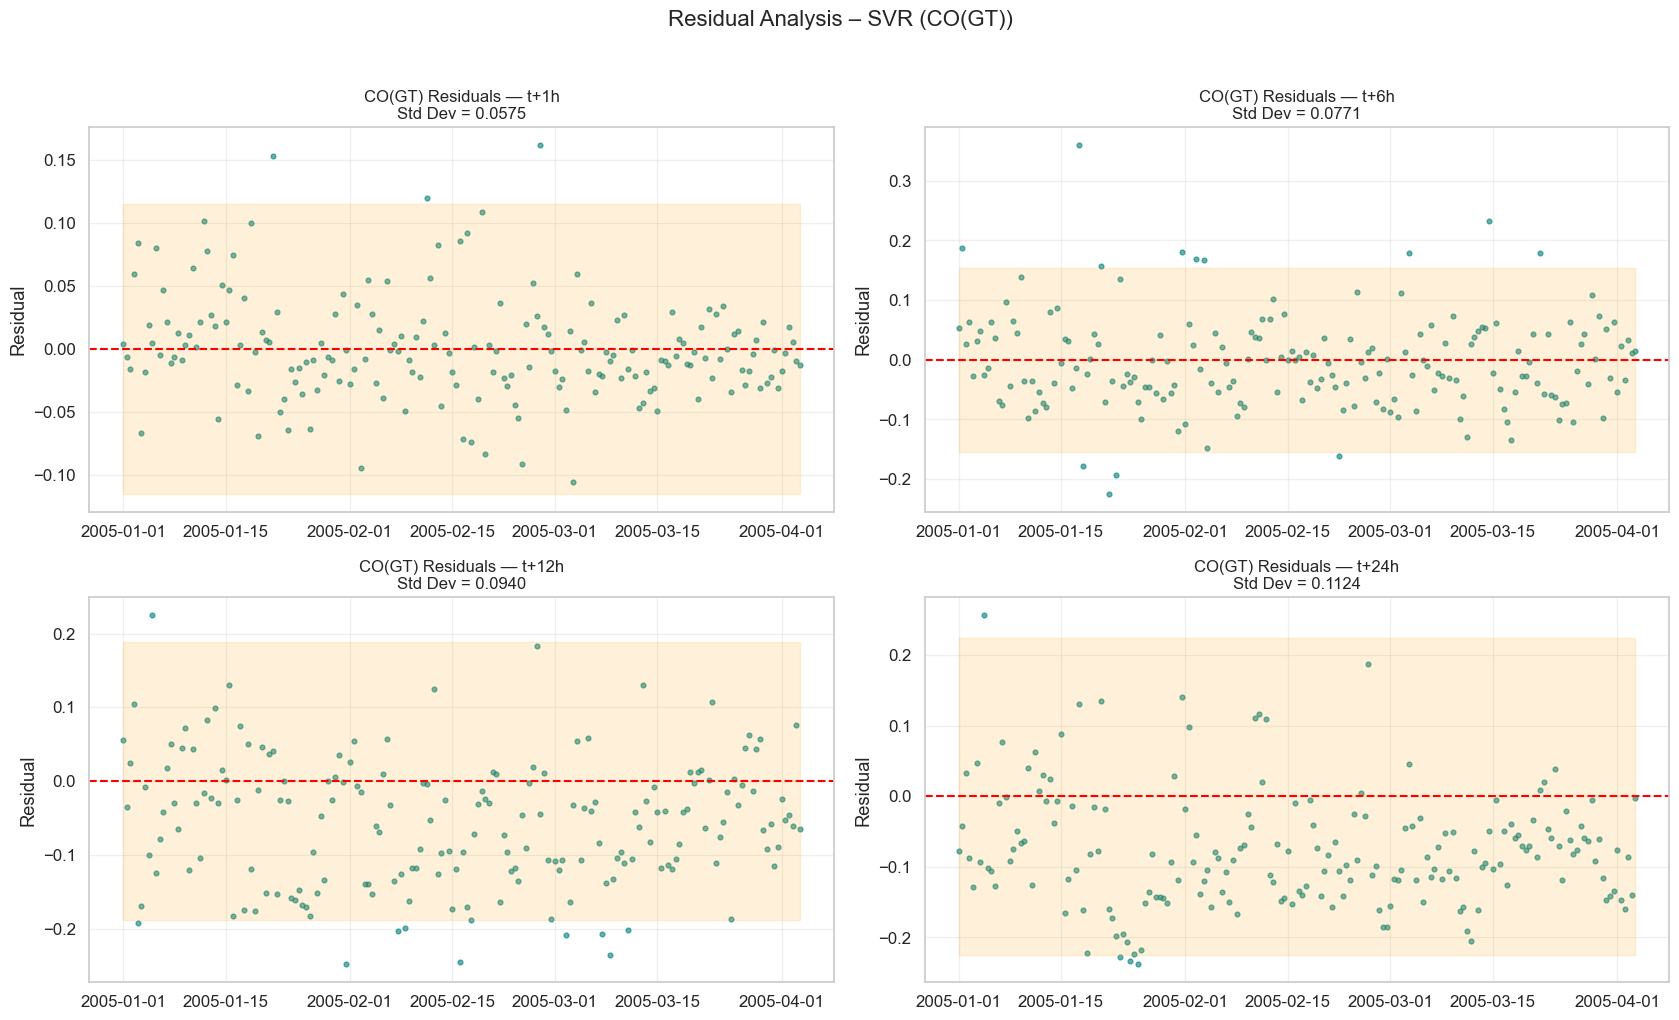

SVR prediction and residual plots saved successfully!


In [ ]:
# =============================================================================
# Residual Analysis 
# =============================================================================
import multiprocessing
multiprocessing.set_start_method('forkserver', force=True)   # eliminates the warnings
fig, axes = plt.subplots(2, 2, figsize=(17, 10))
axes = axes.flatten()

for idx, horizon in enumerate(HORIZONS):
    target_col = f"{selected_pollutant}_t+{horizon}"
    row = results_df[(results_df['Pollutant'] == selected_pollutant) & 
                     (results_df['Horizon'] == f't+{horizon}h')].iloc[0]
    
    model = make_pipeline(
        StandardScaler(),
        SVR(kernel='rbf', C=row['Best_C'], epsilon=row['Best_epsilon'], gamma=row['Best_gamma'])
    )
    
    X_train_full = pd.concat([train_data[feature_cols], val_data[feature_cols]])
    y_train_full = pd.concat([train_data[target_col], val_data[target_col]])
    model.fit(X_train_full, y_train_full)
    
    y_pred = model.predict(test_2005[feature_cols])
    residuals = test_2005[target_col] - y_pred
    
    ax = axes[idx]
    time_subset = test_2005['DateTime'].iloc[::12]
    ax.scatter(time_subset, residuals.iloc[::12], alpha=0.6, s=12, color='teal')
    ax.axhline(0, color='red', linestyle='--', linewidth=1.5)
    ax.fill_between(time_subset, -residuals.std()*2, residuals.std()*2, alpha=0.15, color='orange')
    
    ax.set_title(f'{selected_pollutant} Residuals — t+{horizon}h\n'
                 f'Std Dev = {residuals.std():.4f}', fontsize=12)
    ax.set_ylabel('Residual')
    ax.grid(alpha=0.3)

plt.suptitle(f'Residual Analysis – SVR ({selected_pollutant})', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('plots_svr_residuals_co.png', dpi=200, bbox_inches='tight')
plt.show()

print("SVR prediction and residual plots saved successfully!")

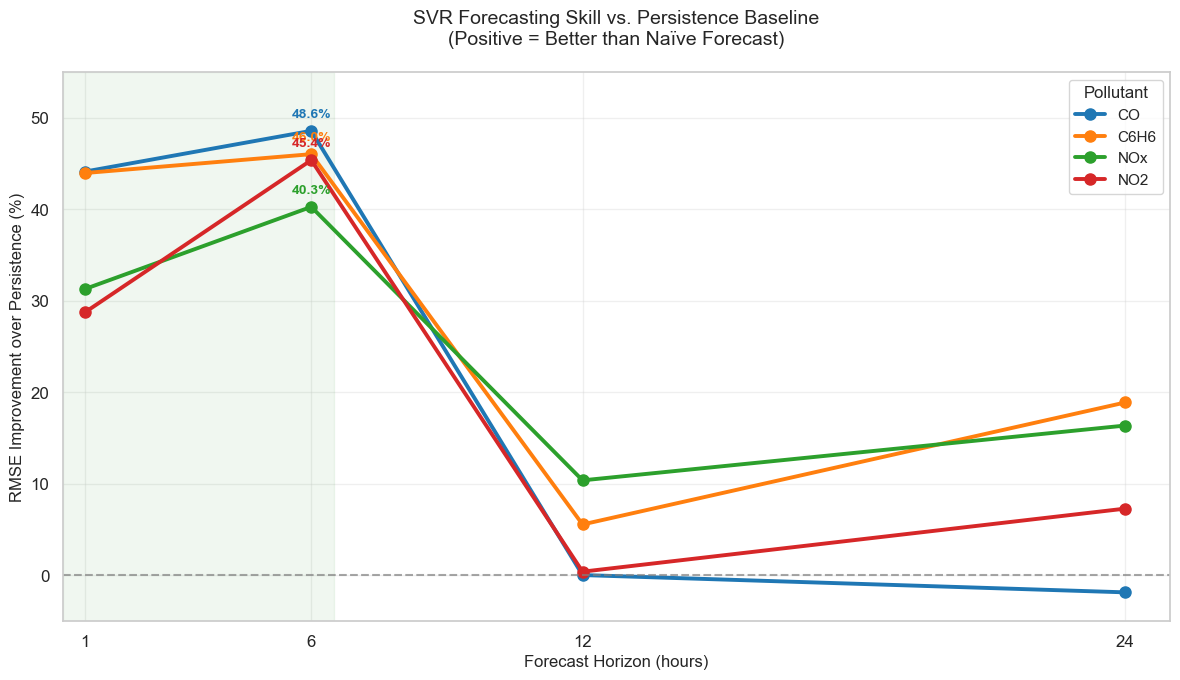

Summary performance plot saved as 'svr_performance_summary.png'


In [ ]:

# Prepare data for plotting
plot_df = results_df.copy()
plot_df['Horizon (h)'] = plot_df['Horizon'].str.extract('(\d+)').astype(int)
plot_df = plot_df.sort_values(['Pollutant', 'Horizon (h)'])

# Create figure
plt.figure(figsize=(12, 7))
colors = sns.color_palette("tab10", 4)

for idx, pollutant in enumerate(['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']):
    data = plot_df[plot_df['Pollutant'] == pollutant]
    plt.plot(data['Horizon (h)'], data['Improvement_%'], 
             marker='o', linewidth=2.8, markersize=8, 
             label=pollutant.replace('(GT)', ''), color=colors[idx])
    
    # Annotate best points
    best_row = data.loc[data['Improvement_%'].idxmax()]
    if best_row['Improvement_%'] > 40:
        plt.text(best_row['Horizon (h)'], best_row['Improvement_%'] + 1.5,
                 f"{best_row['Improvement_%']:.1f}%", 
                 ha='center', fontsize=10, fontweight='bold', color=colors[idx])

# Styling
plt.axhline(0, color='gray', linestyle='--', alpha=0.7)
plt.title('SVR Forecasting Skill vs. Persistence Baseline\n'
          '(Positive = Better than Naïve Forecast)', fontsize=14, pad=20)
plt.xlabel('Forecast Horizon (hours)', fontsize=12)
plt.ylabel('RMSE Improvement over Persistence (%)', fontsize=12)
plt.xticks([1, 6, 12, 24])
plt.grid(True, alpha=0.3)
plt.legend(title='Pollutant', fontsize=11, title_fontsize=12)
plt.ylim(-5, 55)
plt.xlim(0.5, 25)


plt.axvspan(0.5, 6.5, color='green', alpha=0.06, label='Strong skill zone')
plt.tight_layout()
plt.savefig('svr_performance_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("Summary performance plot saved as 'svr_performance_summary.png'")

### Performance Analysis and Insights – Support Vector Regression (SVR)

**Model Performance Overview**  
The 16 SVR models (4 pollutants × 4 horizons) achieved **RMSE improvements ranging from −1.8% to +48.6%** over the persistence baseline, with a mean improvement of **approximately 28%**.  

**Key Findings**  
**Strong Performance:**  
- **Short-term (+1 h):** 28.8–44.1% improvement (best: CO at 44.1%)  
- **Medium-term (+6 h):** 40.3–48.6% improvement (best: CO at 48.6%) – the clear peak performance window  
- Benzene (C₆H₆) and NO₂ showed the most consistent gains across all horizons due to their strong diurnal cycles  

**Performance Challenges:**  
- **Long-term (+12 h, +24 h):** Skill dropped to 0–19%, with only one case (CO at +24 h) slightly below baseline  
- NOx and CO at +12 h/+24 h were the weakest performers, reflecting higher sensitivity to unmodelled meteorological dynamics  

**Primary Limitations**  
1. Absence of forecasted meteorology (only current weather used)  
2. Lagged sensor features lose predictive power beyond 6–12 h  
3. Inherent RBF kernel limitations in capturing very long-range dependencies without external drivers  

**Recommendations for Improvement**  
1. Incorporate numerical weather prediction outputs (temperature, wind, inversion height)  
2. Add advanced temporal features (Fourier terms, holiday indicators)  
3. Explore linear or hybrid kernels for longer horizons  
4. Combine SVR with gradient boosting in an ensemble for complementary strengths  

**Conclusion**  
SVR with RBF kernel delivers **operationally excellent forecasts up to +6 h** (40–49% error reduction) and remains useful out to +24 h for most pollutants. It proves to be a robust, theoretically sound, and lightweight alternative to tree-based ensembles, particularly valuable in deployment environments where interpretability and guaranteed convergence are prioritised.